<a href="https://colab.research.google.com/github/11harini04/MDSProject/blob/master/Web_scraping_NSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install influxdb-client

     |████████████████████████████████| 491kB 2.8MB/s 
     |████████████████████████████████| 112kB 13.9MB/s 
     |████████████████████████████████| 512kB 10.6MB/s 
  Created wheel for ciso8601: filename=ciso8601-2.1.3-cp36-cp36m-linux_x86_64.whl size=28306 sha256=04fc14966e63a588e450c81de4b863d426a61cf030e44a460ff6ccd2001c01ed
  Stored in directory: /root/.cache/pip/wheels/eb/32/e4/13bdaf7e245f82667b21e0cfb03d21224691a47fa9f9bc80a6
  Created wheel for rx: filename=Rx-3.1.0-cp36-none-any.whl size=195489 sha256=668dc688530d02a350528fa94f7169a9c63a1329099fe7f86fbb3889c7bad770
  Stored in directory: /root/.cache/pip/wheels/88/84/32/3daff4afe52d5372cf3691233c2f29f8b498b034f4ef994d0a
Successfully built ciso8601 rx
  Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      Successfully uninstalled pytz-2018.9


In [0]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client import InfluxDBClient

#InfluxDB bucket and token for using InfluxDBClient
bucket = "Stocks"
org = "11harini04@gmail.com"
token = "A11NbY2ifqR8sQGdC8KUtXsmd-5gvFk8ruvlBzdyyFfDmb7bBRVzhoDf2_dOq5WL9J5EQBQpp2oL2vdGRCR8Uw=="
client = InfluxDBClient(url="https://us-west-2-1.aws.cloud2.influxdata.com",token=token)

In [0]:
import requests
import pandas as pd
from datetime import datetime
from bokeh.plotting import figure, show, output_file
from influxdb_client import Point

#API key to extract data from Yahoo Finance
API_KEY = 'GIJPOQVYSQTTJ319'

#Stock of Neyveli India Limited company
stock_name = 'NLCINDIA.BO'

#Scraping data from YahooFinance
r = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=' + stock_name + '&apikey=' + API_KEY)
result = r.json()
dataForAllDays = result['Time Series (Daily)']

#convert to dataframe
df = pd.DataFrame.from_dict(dataForAllDays, orient='index') 

#rename columns
df = df.rename(index=str, columns={"index":"name", "1. open": "open", "2. high": "high", "3. low": "low", "4. close": "close","5. volume":"volume"})

#Changing the datatype 
df.open = df.open.astype(float)
df.close = df.close.astype(float)
df.high = df.high.astype(float)
df.low = df.low.astype(float)
df.volume = df.volume.astype(int)
name = [stock_name]*len(df)  
df['name'] = name
kind = 'Stock'

#Inserting into InfluxDB using InfluxdbClient
date = []
for ind in df.index:
  datetime_object = datetime.strptime(ind,'%Y-%m-%d')
  date.append(datetime_object)
  point = Point(kind).tag("name",df['name'][ind]).field("open",df['open'][ind]).field("close",df['close'][ind]).field("high",df['high'][ind]).field("low",df['low'][ind]).time(time = datetime_object)
  write_api = client.write_api(write_options = SYNCHRONOUS)
  write_api.write(bucket = bucket, org = org, record = point)
df['Date'] = date
df.set_index("Date", inplace = True) 

In [0]:
#Querying from InfluxDB and storing the results in Dataframe
df = pd.DataFrame()
query = 'from(bucket: "Stocks") |> range(start: 2019-11-13, stop:2020-04-12)'
tables = client.query_api().query(query, org=org)
for table in tables:
  field_value = []
  for row in table.records:
    field_name = row.get_field()
    field_value.append(row.get_value())
  df[field_name] = field_value
df['Date'] = date
df.set_index("Date", inplace = True) 

In [32]:
df

,low,high,open,close
Date,,,,
2020-04-08,54.00,55.25,54.40,54.35
2020-04-07,54.20,54.75,54.50,54.25
2020-04-03,52.75,54.75,54.75,53.55
2020-04-01,53.10,54.00,53.35,53.40
2020-03-31,53.70,54.50,54.45,54.25
...,...,...,...,...
2019-11-20,43.15,44.40,43.15,44.00
2019-11-19,43.05,44.70,43.60,43.20
2019-11-18,42.80,44.05,43.60,43.60


In [9]:
!pip install pyramid-arima

     |████████████████████████████████| 604kB 2.8MB/s 


In [33]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(df['close'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=368.763, BIC=381.093, Fit time=0.763 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=397.621, BIC=402.553, Fit time=0.020 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=375.254, BIC=385.118, Fit time=0.269 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=367.069, BIC=376.933, Fit time=0.375 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=368.721, BIC=381.051, Fit time=0.593 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=397.463, BIC=404.861, Fit time=0.082 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=368.718, BIC=381.047, Fit time=1.013 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=370.353, BIC=385.149, Fit time=3.556 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=365.980, BIC=373.377, Fit time=0.282 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 

In [0]:
stepwise_model_fit = stepwise_model.fit(df['close'])
forecast = stepwise_model_fit.predict(n_periods=10)

Text(0.5, 1.0, 'Forecasted plot of Closing price for next 10 days')

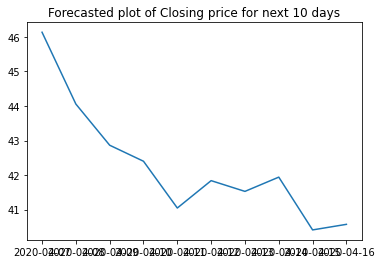

In [35]:
import matplotlib.pyplot as plt
dates = []
for i in range(7,17):
  s = '2020-04-'
  if(len(str(i))==1):
    s = s + '0' + str(i)
  else:
    s = s + str(i)
  dates.append(s)
plt.plot(dates,forecast)
plt.title('Forecasted plot of Closing price for next 10 days')

In [14]:
pip install --ignore-installed --upgrade keras

     |████████████████████████████████| 378kB 2.8MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 2.9MB 7.7MB/s 
     |████████████████████████████████| 20.2MB 225kB/s 
     |████████████████████████████████| 276kB 47.5MB/s 
     |████████████████████████████████| 26.1MB 1.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=c898823a0a0e36b13930569f1edf20eace33ab6c2b50d7383f6b2783eb878442
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built pyyaml
ERROR: qtconsole 4.7.2 has requirement pyzmq>=17.1, but you'll have pyzmq 17.0.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ER

In [0]:

#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt



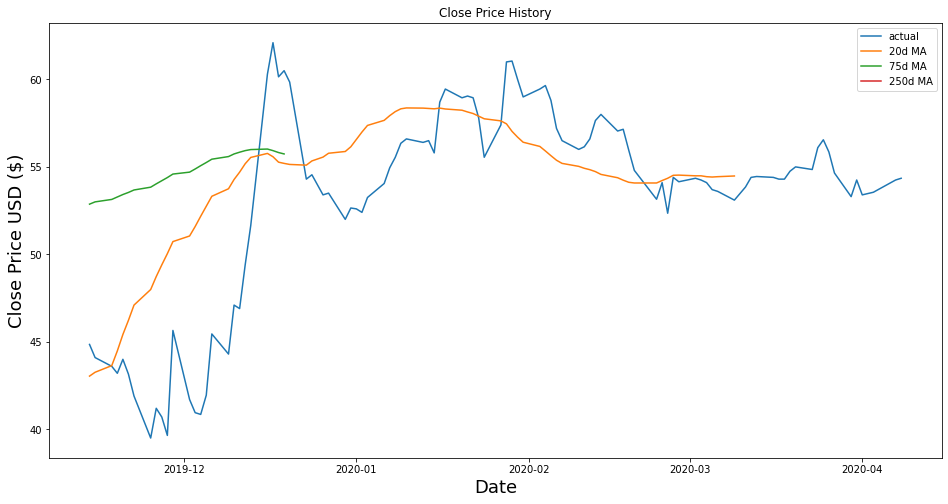

In [37]:
#Smoothing using Moving Averages to identify trends

#fast moving avg with q = 20days
df['20d'] = np.round(df['close'].rolling(window = 20, center = False).mean(), 2)

df['75d'] = np.round(df['close'].rolling(window = 75, center = False).mean(), 2)

#slow moving avg with q = 20days
df['250d'] = np.round(df['close'].rolling(window = 250, center = False).mean(), 2)
plt.figure(figsize=(16,8))
plt.title('Close Price History')

#the closing price is plotted along moving averages
plt.plot(df['close'], label = 'actual')
plt.plot(df['20d'], label ='20d MA')
plt.plot(df['75d'], label ='75d MA')
plt.plot(df['250d'], label ='250d MA')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
leg = plt.legend();
plt.show()


We can identify trends using this graph.

From 250d MA, we see there's 

*   a positive trend from first quarter of 2014 to first quarter of 2015    (bull market)
*   a negative trend from second quarter of 2015 till the end of 2016 (bear market)
*   a positive trend from beginning of 2017 till first quarter of 2018   (bull market)
*  a negative trend from second quarter of 2018 until now(bear market) 









In [38]:
data = df.filter(['close'])

dataset = data.values

training_data_len = math.ceil( len(dataset) * .8 )

training_data_len

80

In [39]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.65707965],
       [0.65265487],
       [0.62168142],
       [0.61504425],
       [0.65265487],
       [0.61061947],
       [0.67035398],
       [0.72345133],
       [0.75442478],
       [0.73451327],
       [0.67920354],
       [0.68584071],
       [0.67477876],
       [0.65486726],
       [0.65486726],
       [0.65929204],
       [0.66150442],
       [0.65929204],
       [0.63495575],
       [0.60176991],
       [0.62389381],
       [0.62831858],
       [0.6460177 ],
       [0.65265487],
       [0.65707965],
       [0.64823009],
       [0.65929204],
       [0.56858407],
       [0.6460177 ],
       [0.6039823 ],
       [0.67699115],
       [0.72787611],
       [0.78097345],
       [0.77654867],
       [0.81858407],
       [0.80309735],
       [0.75663717],
       [0.73672566],
       [0.7300885 ],
       [0.75221239],
       [0.78318584],
       [0.8539823 ],
       [0.89159292],
       [0.88274336],
       [0.86283186],
       [0.90707965],
       [0.95353982],
       [0.951

In [40]:
train_data = scaled_data[0:training_data_len , :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<= 61:
    print(x_train)
    print(y_train)
    print()

[array([0.65707965, 0.65265487, 0.62168142, 0.61504425, 0.65265487,
       0.61061947, 0.67035398, 0.72345133, 0.75442478, 0.73451327,
       0.67920354, 0.68584071, 0.67477876, 0.65486726, 0.65486726,
       0.65929204, 0.66150442, 0.65929204, 0.63495575, 0.60176991,
       0.62389381, 0.62831858, 0.6460177 , 0.65265487, 0.65707965,
       0.64823009, 0.65929204, 0.56858407, 0.6460177 , 0.6039823 ,
       0.67699115, 0.72787611, 0.78097345, 0.77654867, 0.81858407,
       0.80309735, 0.75663717, 0.73672566, 0.7300885 , 0.75221239,
       0.78318584, 0.8539823 , 0.89159292, 0.88274336, 0.86283186,
       0.90707965, 0.95353982, 0.95132743, 0.7920354 , 0.71017699,
       0.80973451, 0.86061947, 0.86504425, 0.86061947, 0.88274336,
       0.84955752, 0.72123894, 0.75221239, 0.74778761, 0.75663717])]
[0.7455752212389379]

[array([0.65707965, 0.65265487, 0.62168142, 0.61504425, 0.65265487,
       0.61061947, 0.67035398, 0.72345133, 0.75442478, 0.73451327,
       0.67920354, 0.68584071, 0.674

In [0]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [42]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(20, 60, 1)

In [0]:

#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [44]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
20/20 [==============================] - 1s 71ms/step - loss: 0.0900


In [0]:
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [46]:
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

#Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#Get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

7.106441612646563

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


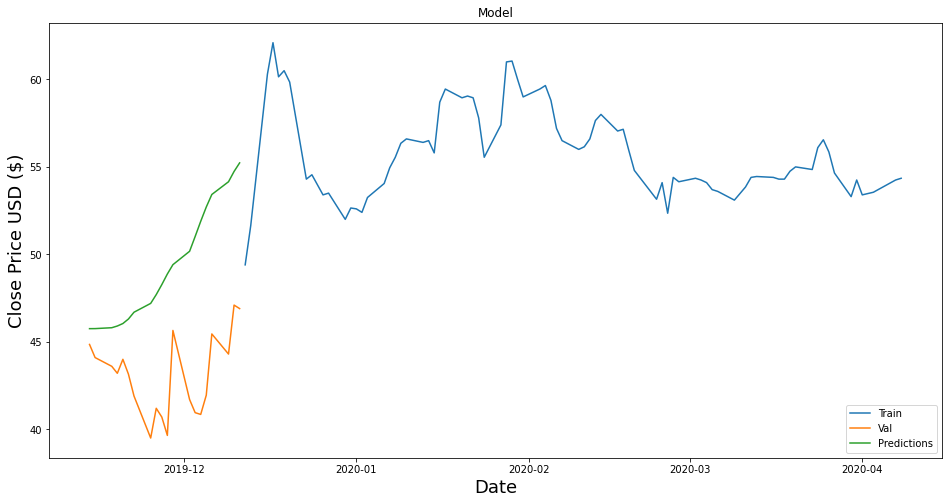

In [47]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [48]:
valid

,close,Predictions
Date,,
2019-12-11,46.90,55.229172
2019-12-10,47.10,54.738491
2019-12-09,44.30,54.149998
2019-12-06,45.45,53.423153
2019-12-05,41.95,52.705620
2019-12-04,40.85,51.888496
2019-12-03,40.95,51.021503
2019-12-02,41.70,50.175087
2019-11-29,45.65,49.410172


In [49]:
!pip install PyPortfolioOpt

In [0]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


In [51]:
mu = expected_returns.mean_historical_return(df['close'])        
S = risk_models.sample_cov(df['close'])           
ef = EfficientFrontier(mu, S)        
raw_weights = ef.max_sharpe()        
cleaned_weights = ef.clean_weights()        
perf = ef.portfolio_performance(verbose=True)        
ef.__dict__

/usr/local/lib/python3.6/dist-packages/pypfopt/expected_returns.py:67: RuntimeWarning: prices are not in a dataframe
  warnings.warn("prices are not in a dataframe", RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/pypfopt/risk_models.py:61: RuntimeWarning: prices are not in a dataframe
  warnings.warn("prices are not in a dataframe", RuntimeWarning)


OptimizationError: ignored